# Mecanismo de Recomendação de séries
## Objetivo
O objetivo do modelo será recomendar séries ao usuário que estejam de acordo com os gostos dele, e a base para isso serão as avaliações feitas pelos usuários, além dos gêneros das séries avaliadas. Para que isso fosse feito, vimos que temos que responder as perguntas a seguir:
* Como "posicionar" um usuário próximo a outros usuários que consomem (e avaliam positivamente) o mesmo conteúdo?
* Quais dados dos usuários serão o critério para esse posicionamento?
* Uma vez posicionado, como será feita a escolha dos títulos a serem recomendados?

In [3]:
import collections
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [4]:
reviews_tv_shows_df = pd.read_csv('./reviews_tv_shows.csv')
reviews_tv_shows_df

,Unnamed: 0,tv_show,16,18,35,37,80,878,9648,10751,...,10762,10763,10764,10765,10766,10767,10768,user,rating,id_y
0,0,Invincible,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,ChrisSawin,10.000000,6058917c5c071b00546ccab3
1,1,The Flash,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,Tanasia,5.195675,5f98b89877e1f600358ada9f
2,2,The Flash,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,BruhDev,5.195675,605e5e40d2f5b500286aa8ed
3,3,The Good Doctor,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,drtvnut89,10.000000,5a0a07c192514131210073ec
4,4,The Handmaid's Tale,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,Rangan,5.195675,59bd8f6b92514135510185ab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7562,7562,Absentia,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,larz9,10.000000,5b1406c3c3a368628e01ba6d
7563,7563,Quantico,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,suspectedowl,10.000000,5a04c360c3a36833cf006629
7564,7564,Given,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,ausher8,8.000000,5fbb8ace8d22fc003e7d242b
7565,7565,The Haunting of Hill House,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,Splinter,4.000000,5bce80090e0a266242003202


## Transformação do Dataset
Atualmente temos um dataset em que cada linha representa uma avaliação feita por algum usuário. Como o elemento central do nosso modelo são os usuários, precisamos transformar esse dataset para que cada linha represente um usuário, criando novas colunas para cada série e então colocando como valor dessas colunas as notas dadas nas avalições.

In [5]:
users_df = pd.pivot_table(reviews_tv_shows_df, values='rating', index='user', columns='tv_show')
users_df

tv_show,13 Reasons Why,3Below: Tales of Arcadia,A Discovery of Witches,A Million Little Things,AIBOU: Tokyo Detective Duo,Absentia,Agries Melisses,Akame ga Kill!,Alexa & Katie,All American,...,Westworld,What We Do in the Shadows,White Collar,Wizards: Tales of Arcadia,Wynonna Earp,Xena: Warrior Princess,YOU,Your Lie in April,iCarly,iZombie
user,,,,,,,,,,,,,,,,,,,,,
AKJETJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN
Abro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AdamRife,4.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN
Aditya@13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN
Ahstaroth,2.0,NaN,NaN,9.0,NaN,3.0,NaN,NaN,NaN,NaN,...,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tmdbsom,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,...,NaN,NaN,NaN,NaN,9.0,NaN,10.0,10.0,10.0,NaN
tomk1,10.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,10.0,NaN,2.0,NaN,NaN,NaN
wan_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_columns = users_df.columns

for i in range(0,242):
    s = users_df[df_columns[i]].value_counts(normalize=True)
    missing = users_df[df_columns[i]].isnull()
    
    users_df.loc[missing,df_columns[i]] = np.random.choice(s.index, size=len(users_df[missing]),p=s.values)
users_df

tv_show,13 Reasons Why,3Below: Tales of Arcadia,A Discovery of Witches,A Million Little Things,AIBOU: Tokyo Detective Duo,Absentia,Agries Melisses,Akame ga Kill!,Alexa & Katie,All American,...,Westworld,What We Do in the Shadows,White Collar,Wizards: Tales of Arcadia,Wynonna Earp,Xena: Warrior Princess,YOU,Your Lie in April,iCarly,iZombie
user,,,,,,,,,,,,,,,,,,,,,
AKJETJ,10.0,4.0,7.0,1.0,4.0,1.0,0.0,5.0,1.0,6.0,...,8.0,9.0,3.0,1.0,0.0,4.0,10.0,2.0,3.0,3.0
Abro,2.0,0.0,9.0,6.0,3.0,7.0,7.0,8.0,8.0,8.0,...,2.0,8.0,4.0,6.0,1.0,6.0,8.0,0.0,8.0,4.0
AdamRife,4.0,3.0,0.0,9.0,4.0,5.0,0.0,5.0,6.0,10.0,...,0.0,7.0,5.0,7.0,7.0,4.0,10.0,0.0,9.0,2.0
Aditya@13,4.0,1.0,6.0,8.0,0.0,1.0,6.0,2.0,6.0,1.0,...,4.0,5.0,1.0,6.0,10.0,8.0,2.0,1.0,9.0,2.0
Ahstaroth,2.0,1.0,0.0,9.0,6.0,3.0,6.0,5.0,8.0,5.0,...,5.0,0.0,1.0,4.0,6.0,6.0,1.0,7.0,9.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tmdbsom,7.0,3.0,4.0,10.0,1.0,8.0,5.0,2.0,4.0,1.0,...,8.0,8.0,10.0,1.0,9.0,3.0,10.0,10.0,10.0,5.0
tomk1,10.0,4.0,5.0,4.0,9.0,4.0,2.0,9.0,0.0,0.0,...,7.0,5.0,1.0,1.0,10.0,10.0,2.0,10.0,8.0,9.0
wan_,0.0,1.0,10.0,1.0,0.0,9.0,5.0,0.0,9.0,10.0,...,1.0,9.0,5.0,1.0,0.0,6.0,3.0,3.0,8.0,4.0


In [7]:
users_df.isnull().sum()

tv_show
13 Reasons Why                0
3Below: Tales of Arcadia      0
A Discovery of Witches        0
A Million Little Things       0
AIBOU: Tokyo Detective Duo    0
                             ..
Xena: Warrior Princess        0
YOU                           0
Your Lie in April             0
iCarly                        0
iZombie                       0
Length: 242, dtype: int64

## O Modelo
A Técnica de Machine Learning a ser utilizada será clusterização, essa foi a forma escolhida para agrupar os usuários baseado nas diferenças nas avaliações. Para essa PoC, utilizaremos o KMeans por ter sido o caminho que vimos em sala de aula com mais extensão, e ser suficiente para esse modelo inicial.

No código a seguir faremos a escolha do número de clusters ótimo para o modelo, em seguida criaremos o modelo a faremos a clusterização. 

--------------------

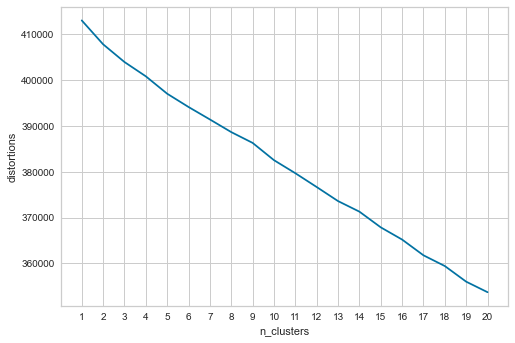

In [8]:
distortions = []
n_clusters =  range(1,21)


for n in n_clusters:
    print("-", end = '')
    kmeans_model = KMeans(n_clusters=n, random_state=42)
    kmeans_model.fit(users_df)
    distortions.append(kmeans_model.inertia_)
    
elbow_plot_df = pd.DataFrame({'n_clusters': n_clusters, 'distortions': distortions})
sns.lineplot(x='n_clusters', y='distortions', data = elbow_plot_df)
plt.xticks(n_clusters)
plt.show()

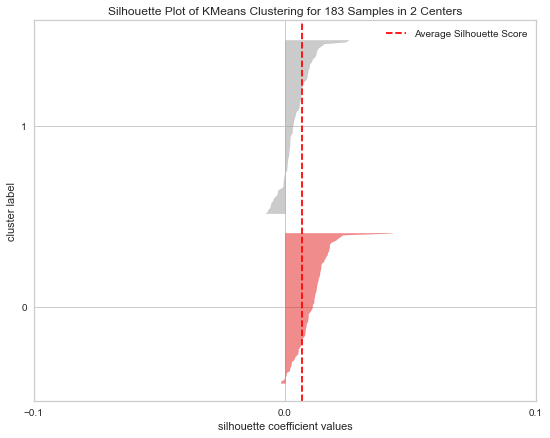

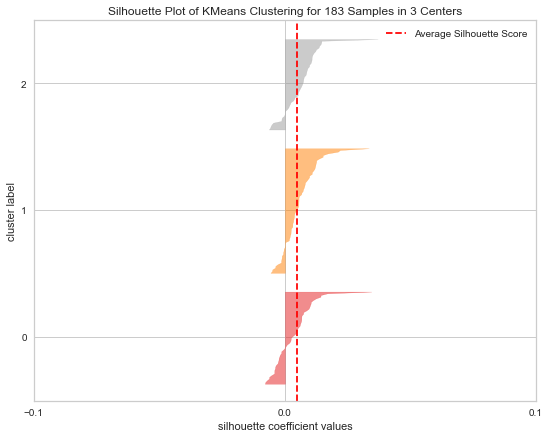

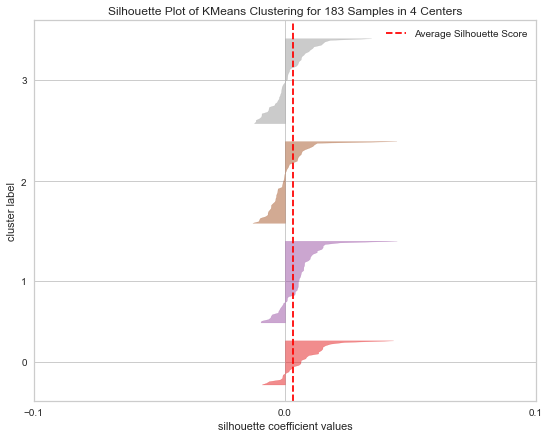

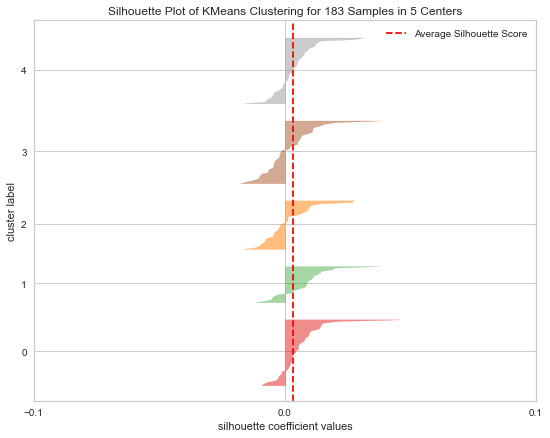

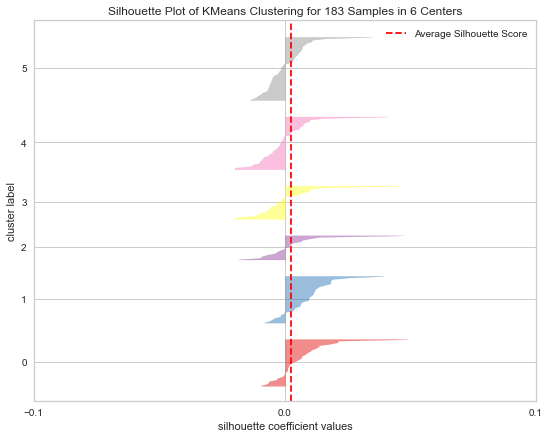

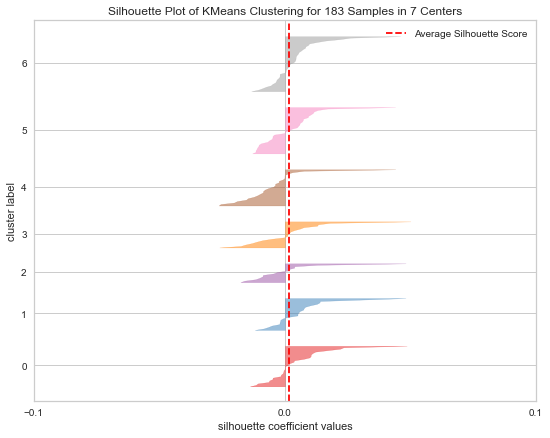

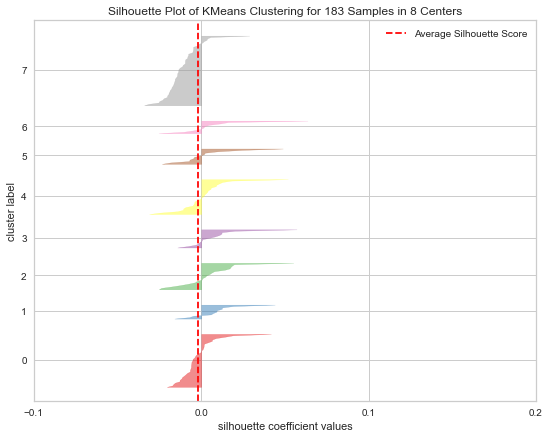

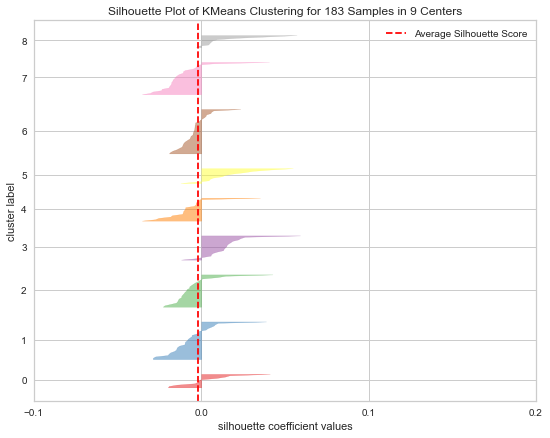

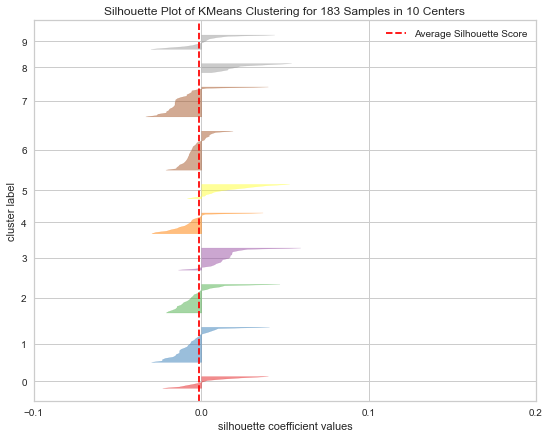

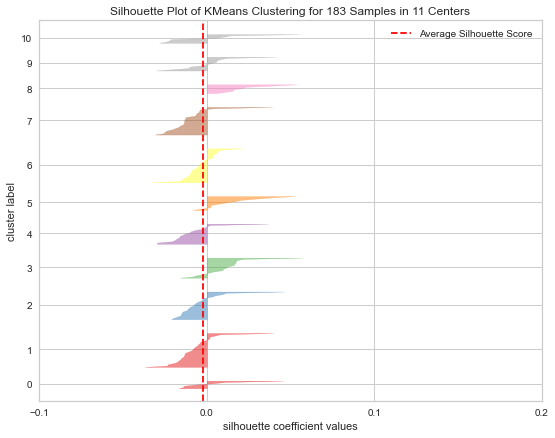

In [9]:
for i in range(2,12):
    fig = plt.figure(figsize=(9, 7))
    model = KMeans(i, random_state=42)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(users_df)
    visualizer.poof()

kmeans Predict:
[0 1 0 1 5 1 5 0 1 5 0 5 3 0 5 3 2 1 1 4 1 0 3 3 5 4 5 4 3 5 1 4 3 5 0 1 5
 5 4 5 3 4 4 5 3 3 3 1 5 0 1 0 4 0 1 0 5 5 4 3 3 1 2 1 4 4 4 1 5 3 1 0 4 0
 5 1 4 1 4 5 3 5 5 2 2 0 1 2 2 3 3 0 0 4 1 4 4 5 0 5 1 5 5 0 5 0 0 1 5 2 5
 4 4 4 2 1 3 3 2 0 1 2 4 1 0 0 4 0 4 4 0 1 1 5 5 1 4 5 2 5 4 5 5 3 4 5 0 1
 2 0 3 5 1 4 4 1 0 0 2 5 4 5 2 5 4 3 3 2 1 0 5 4 5 0 5 0 5 4 4 3 4 2 2]

Clustering Score:
394105.6381361778


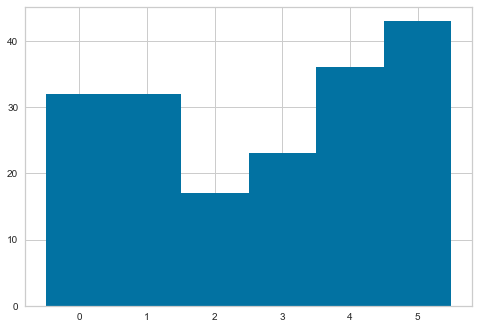

In [10]:
kmeans_model = KMeans(n_clusters=6, random_state=42).fit(users_df)
clustering_pred = kmeans_model.predict(users_df)

unique_counts = collections.Counter(e for e in clustering_pred)
plt.bar(unique_counts.keys(), unique_counts.values(), 1)

print("kmeans Predict:\n{}\n".format(clustering_pred))
print("Clustering Score:\n{}".format(kmeans_model.inertia_))

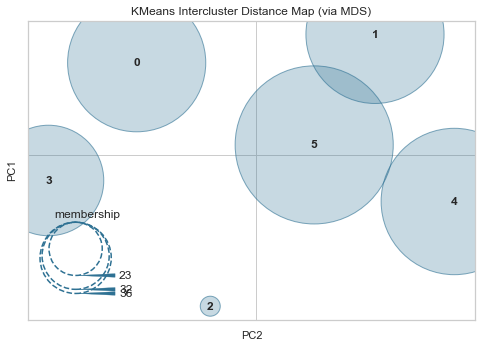

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [11]:
visualizer = InterclusterDistance(kmeans_model)
visualizer.fit(users_df)
visualizer.poof()

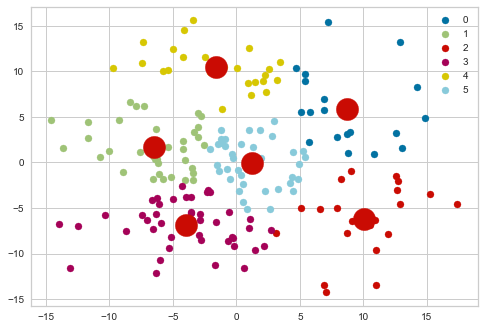

In [22]:
pca = PCA(n_components= 2, random_state=0)

p_components = pca.fit_transform(users_df)
labels = kmeans_model.fit_predict(p_components)
centroids = kmeans_model.cluster_centers_
unique_labels = np.unique(labels)

for i in unique_labels:
    plt.scatter(p_components[labels == i , 0] , p_components[labels == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 500, color = 'r')
plt.legend()
plt.show()

## Recomendação
Para realizar a recomendação para um novo usuário da plataforma, ele será posicionado em um cluster e então será recomendado para ele as séries com maior média naquele cluster, desde que ele não a tenha assistido.

In [ ]:
new_user = users_df.sample()

for i in range(0,100):
    rand_user = users_df.sample()
    rand_column = df_columns[np.random.randint(0,242)]
    new_user[rand_column] = rand_user[rand_column]

new_user['user'] = 'antonioalmeida'

new_user_cluster = int(kmeans_model.predict(new_user))




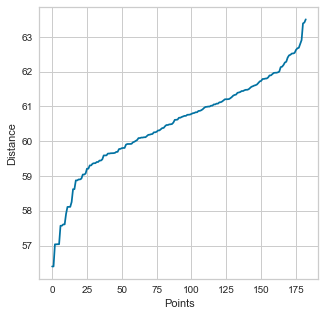

In [25]:
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(users_df)

distances, indices = neighbors.kneighbors(users_df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("Distance_curve.png", dpi=300)

In [26]:
dbscan_model = DBSCAN(eps=62,min_samples=5).fit(df_values)
db_clusters = dbscan_model.labels_
db_clusters
# colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
# vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
# plt.scatter(df_values[:,0], df_values[:,1], c=vectorizer(db_clusters))


array([ 0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0, -1,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0, -1,
       -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0, -1,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0])